#Are America's Nuclear Plants Doomed?  -- IPython Process Notebook

Final Project for CS109 || Sam Huntington, Danny Chua, and Max DeCurtins

##Table of Contents

This project involved several steps and a lot of different code. For ease of presentation, some of that code is kept in separate workbooks:<br>

Webscraping:
- Natural Gas and Coal commodity prices:        *~/1. Data Wrangling - MISO/Commodity Prices*
- Wind generation in MISO:                      *~/1. Data Wrangling - MISO/Wind Generation*
- Electricity Demand in MISO:                   *~/1. Data Wrangling - MISO/Demand Scraper*
- PJM nodal electricity prices:                 *~/4. PJM Data/pjm_dayahead*

Initial EDA:
- Coal, gas, and wind generation over time:      *~/2. EDA/Features over time*
- Scatter plots of elec prices against coal/NG:  *~/2. EDA/Relationship between variables*





##Modules

In [5]:
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import requests
import json
import datetime

##Project Motivation and Overview

Recently, owners of nuclear power plants in the midwest have seen their [profitability decline](http://articles.chicagotribune.com/2014-03-09/business/ct-exelon-closing-nuclear-plants-0308-biz-20140309_1_quad-cities-plant-byron-plant-exelon). In particular, Exelon corporation, the owner of several nuclear plants in northern Illinois, has lobbied for policy changes to secure their revenues and ensure their ongoing financial viability. These arguments are cast against the backdrop of an electricity sector being pushed to integrate more low-carbon sources of electricity. As nuclear currently constitutes the [largest source](https://www.eia.gov/tools/faqs/faq.cfm?id=427&t=3) of low-carbon power in the US, shuttering of these plants would make it more difficult to comply with the EPA's [Clean Power Plan](http://www2.epa.gov/cleanpowerplan/clean-power-plan-existing-power-plants) regulations, and, more generally, would make it more difficult to achieve the long-term emissions reductions neccessary to avoid the worst effects of climate change. Policymakers are now faced with the dilemna of whether or not and by how much to support these plants. 

This raises several interesting questions. Like all power plants, nuclear generator revenues are a function of electricity prices - but what factors drive electricity prices? What recent trends have resulted in depressed electricity prices? How accurately could we forecast future prices? If we were able to do so effectively it could inform policymakers about the conditions under which subsidies or other support instruments might be justified, and perhaps give them a rough estimate (upper and lower bound) of the level of support needed. 

This policy debate, and the associated questions, served as the motivation for this project. The goal at the outset was to develop a predictive model of the electricity prices.

##Initial Questions (sam: i think this should go at the end...)

#####1. What factors drive electricity prices?
As in any competitive market, wholesale electricity prices are a function of [supply and demand](http://www.nordpoolspot.com/How-does-it-work/). Prices are set by auction where generators submit bids roughly equivalent to their operating cost (for nuclear plants this may be the cost of maintenance, while for gas and coal plants this is the cost of fuel. Wind is free and is therefore always dispatched). Gas and coal plants are often the marginal generators (the last to clear the auction and set the price) and therefore their fuel costs are highly correlated with [electricity prices](http://www.eia.gov/EnergyExplained/index.cfm?page=electricity_factors_affecting_prices). Wind generation, which is growing rapidly, reduces electricity prices by [pushing out the supply curve](https://en.wikipedia.org/wiki/Merit_order).  

For these reasons we chose the following features to use in our predictive model:
- electricity demand
- natural gas prices
- coal prices
- wind generation

#####2. What trends have resulted in depressed electricity prices?
see EDA

#####3. How accurately can we forecast future electricity prices?
TBD...

#####4. What is the impact of increased wind generation on future electricity prices?
TBD..

#####5. What is the impact of increased natural gas prices on future electricity prices?
TBD...

##Data Collection and Processing

###Context
Since nuclear plant revenues are a function of the price of electricity, and the price of electricity varies by location, it is important to understand where precisely the plants are located so that we can be confident we are working with the right data. The image below shows the locations of Exelon's six nuclear plants in northern Illinois. 

<img src="nukes.png">
<small><small>Source: Nuclear Plant location: http://www.eia.gov/state/maps.cfm, Power System Map: http://www.miso-pjm.com/

While the plants are all located in the [PJM](http://www.pjm.com/) system (a single regional market for wholesale electricity), the area where the plants are located is surrounded by a different system: [MISO](https://www.misoenergy.org/Pages/Home.aspx). This is important because the two systems are highly interconnected, meaning power flows easily between the two systems and factors affecting prices in one system also affect prices in the other. This effectively doubled our data collection task.

The remainder of this section details how we cleaned and processed each of our main data sources (actual scraping is done in other workbooks - see TOC as top).

###PJM Prices
The nuclear plants identified above are located at specific "nodes", whose IDs ("pnodeID" in the table below) we used to scrape their corresponding prices from the PJM website. Some plants connect to multiple nodes (one for each reactor), in which case we average them. The prices are at an hourly granularity for the years 2008-2015 (68k rows).

In [37]:
pjmdf = pd.read_csv('4. PJM Data/rawdf_pjm_dayahead.csv')
pjmdf.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
pjmdf.head(2)

,pnodeId,price_01,price_02,price_03,price_04,price_05,price_06,price_07,price_08,price_09,price_10,price_11,price_12,price_13,price_14,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24,publishDate
0,32417601,24.15,23.1,21.91,21.08,20.84,21.32,22.55,23.86,24.42,25.15,25.39,26.29,25.84,25.71,25.55,25.44,26.30,42.40,60.56,54.69,45.31,34.56,29.84,25.54,2008-01-01
1,32417601,26.43,25.7,25.58,25.27,25.53,30.45,55.32,66.16,70.70,66.22,63.54,53.78,46.65,44.25,39.70,37.93,40.74,81.39,96.11,82.96,74.83,62.65,50.67,37.44,2008-01-02


This is an inconvenient structure, so we reformat:

In [38]:
idx = pd.date_range('1/1/2008', '11/01/2015 23:00:00', freq = 'H')
df = pd.DataFrame(index = idx)

for node in pjmdf['pnodeId'].unique():
    nodedf = pjmdf[pjmdf['pnodeId']==node]
    nodedf = nodedf.drop('pnodeId',1)
    nodedf = nodedf.drop('publishDate',1)
    nodedf = nodedf.fillna(0)
    nodedf = nodedf.stack()
    col_name = 'lmp_' + str(node)[-3:]
    nodedf.index = idx
    df[col_name] = nodedf

fulldf = pd.DataFrame(index = idx)

fulldf['Clinton_LMP'] = df['lmp_673']
fulldf['LaSalle_LMP'] = df[["lmp_525", "lmp_527"]].mean(axis=1)
fulldf['Dresden_LMP'] = df[["lmp_545", "lmp_547"]].mean(axis=1)
fulldf['Braidwood_LMP'] = df[["lmp_599", "lmp_601"]].mean(axis=1)
fulldf['QuadCities_LMP'] = df[["lmp_629", "lmp_631"]].mean(axis=1)
fulldf['Byron_LMP'] = df[["lmp_633", "lmp_635"]].mean(axis=1)
fulldf.head() 

,Clinton_LMP,LaSalle_LMP,Dresden_LMP,Braidwood_LMP,QuadCities_LMP,Byron_LMP
2008-01-01 00:00:00,42.90,24.055,24.390,24.145,23.450,23.580
2008-01-01 01:00:00,39.33,23.015,23.320,23.100,22.400,22.455
2008-01-01 02:00:00,35.57,21.840,22.125,21.905,21.340,21.320
2008-01-01 03:00:00,34.19,21.010,21.275,21.080,20.535,20.480
2008-01-01 04:00:00,33.14,20.770,21.035,20.840,20.330,20.255


###PJM Electricity Demand Data

In [39]:
# Load raw data from web scraper
ldf = pd.read_csv('data/PJM_hourly_load_08_15.csv')
ldf = ldf.drop('DATE',1)
ldf = ldf.drop('COMP',1)
ldf = ldf.drop('Unnamed: 26',1)
ldf = ldf.drop('Unnamed: 27',1)
ldf = ldf.fillna(0)
ldf = ldf.stack()
idx = pd.date_range('1/1/2008', periods = len(ldf), freq = 'H')
ldf.index = idx

#trim it to appropirate length and add into price dataframe
d = '2015-11-01 23:00:00'
ldf = ldf.ix[:d]
fulldf['Load_PJM_West'] = ldf
fulldf.head()

,Clinton_LMP,LaSalle_LMP,Dresden_LMP,Braidwood_LMP,QuadCities_LMP,Byron_LMP,Load_PJM_West
2008-01-01 00:00:00,42.90,24.055,24.390,24.145,23.450,23.580,33534
2008-01-01 01:00:00,39.33,23.015,23.320,23.100,22.400,22.455,32632
2008-01-01 02:00:00,35.57,21.840,22.125,21.905,21.340,21.320,31828
2008-01-01 03:00:00,34.19,21.010,21.275,21.080,20.535,20.480,31565
2008-01-01 04:00:00,33.14,20.770,21.035,20.840,20.330,20.255,31542


####PJM & MISO Wind Generation Data

In [40]:
# PJM
pjm_wdf = pd.read_csv('data/PJM_Wind/PJM_hourly_wind_08_15.csv')
pjm_wdf = pjm_wdf.drop('DATE',1)
pjm_wdf = pjm_wdf.drop('COMP',1)
pjm_wdf = pjm_wdf.fillna(0)
pjm_wdf = pjm_wdf.stack()
num_hours = len(pjm_wdf)
idx = pd.date_range('1/1/2008', periods = num_hours, freq = 'H')
pjm_wdf.index = idx

# MISO
wdf = pd.read_csv('data/MISO_wind_hourly.csv')
wdf = wdf.drop('Date',1)
num_hours = len(wdf)
idx = pd.date_range('1/1/2008', periods = num_hours, freq = 'H')
wdf.index = idx

# Trim both data sets to an equal size
d = '2015-11-01 23:00:00'
pjm_wdf = pjm_wdf.ix[:d]
wdf = wdf.ix[:d]

# Merge into a single df
wdf['Wind_PJM'] = pjm_wdf
wdf.columns = ['Wind_MISO_MWh', 'Wind_PJM_MWh']
# d = '2015-11-01 23:00:00'
# wdf_trim = wdf.ix[:d]
fulldf = pd.merge(fulldf, wdf, left_index=True, right_index=True)
fulldf.head()

,Clinton_LMP,LaSalle_LMP,Dresden_LMP,Braidwood_LMP,QuadCities_LMP,Byron_LMP,Load_PJM_West,Wind_MISO_MWh,Wind_PJM_MWh
2008-01-01 00:00:00,42.90,24.055,24.390,24.145,23.450,23.580,33534,1104.05,697.102
2008-01-01 01:00:00,39.33,23.015,23.320,23.100,22.400,22.455,32632,1210.31,679.046
2008-01-01 02:00:00,35.57,21.840,22.125,21.905,21.340,21.320,31828,1173.34,632.607
2008-01-01 03:00:00,34.19,21.010,21.275,21.080,20.535,20.480,31565,1146.36,612.350
2008-01-01 04:00:00,33.14,20.770,21.035,20.840,20.330,20.255,31542,1179.32,620.483


####Natural Gas Data

In [41]:
# Build empty Df with date index 
idx = pd.date_range('1/1/2008', '11/01/2015', freq = 'D')
ngdf = pd.DataFrame(index=idx)

# read in NG daily data
ng_raw = pd.read_csv('data/NGPrices.csv')
d = '2008-01-01'
ng_raw = ng_raw[ng_raw['date']>=d]
ng_raw['date'] = pd.to_datetime(ng_raw['date'])
ng_raw = ng_raw.set_index('date')

# map raw daily data to empty df with full dates, interpolate missing values
ngdf['NG_HH'] = ng_raw
ngdf = ngdf.interpolate(method='time')
ngdf.values[0] = ngdf.values[1]
ngdf.head()

# add a column for each hour of day
for i in range (23):
    ngdf[i] = ngdf['NG_HH']

# stack columns and replace index with hourly
ngdf = ngdf.stack()
idx = pd.date_range('1/1/2008', periods = len(ngdf), freq = 'H') 
ngdf.index = idx
fulldf['NatGas_Price'] = ngdf
fulldf.head()

,Clinton_LMP,LaSalle_LMP,Dresden_LMP,Braidwood_LMP,QuadCities_LMP,Byron_LMP,Load_PJM_West,Wind_MISO_MWh,Wind_PJM_MWh,NatGas_Price
2008-01-01 00:00:00,42.90,24.055,24.390,24.145,23.450,23.580,33534,1104.05,697.102,7.83
2008-01-01 01:00:00,39.33,23.015,23.320,23.100,22.400,22.455,32632,1210.31,679.046,7.83
2008-01-01 02:00:00,35.57,21.840,22.125,21.905,21.340,21.320,31828,1173.34,632.607,7.83
2008-01-01 03:00:00,34.19,21.010,21.275,21.080,20.535,20.480,31565,1146.36,612.350,7.83
2008-01-01 04:00:00,33.14,20.770,21.035,20.840,20.330,20.255,31542,1179.32,620.483,7.83


####MISO Electricity Demand Data

In [42]:
mdf = pd.read_csv('data/Load_MISO_central_west.csv')
mdf.columns = ['date','Load_MISO_Central']
idx = pd.date_range('7/6/2009', periods = len(mdf), freq = 'H') 
mdf.index = idx
mdf = mdf.drop('date',1)
inds = pd.isnull(mdf).any(1).nonzero()[0]
mdf.iloc[inds[0]] = np.mean([mdf.iloc[inds[0]+1][0],mdf.iloc[inds[0]-1][0]])
fulldf['Load_MISO_Central'] = mdf
fulldf.head(2)

,Clinton_LMP,LaSalle_LMP,Dresden_LMP,Braidwood_LMP,QuadCities_LMP,Byron_LMP,Load_PJM_West,Wind_MISO_MWh,Wind_PJM_MWh,NatGas_Price,Load_MISO_Central
2008-01-01 00:00:00,42.90,24.055,24.39,24.145,23.45,23.580,33534,1104.05,697.102,7.83,NaN
2008-01-01 01:00:00,39.33,23.015,23.32,23.100,22.40,22.455,32632,1210.31,679.046,7.83,NaN


Note that MISO demand data doesn't go back as far as the others (only to 2008-07-06, where the others go back to 2008-01-01). We trim this later.

###Coal Prices

note that they are mine-mouth, rather than delivered prices...which probably throws off the correlation

##Exploratory Data Analysis

###Longitudinal plot of prices at each reactor location

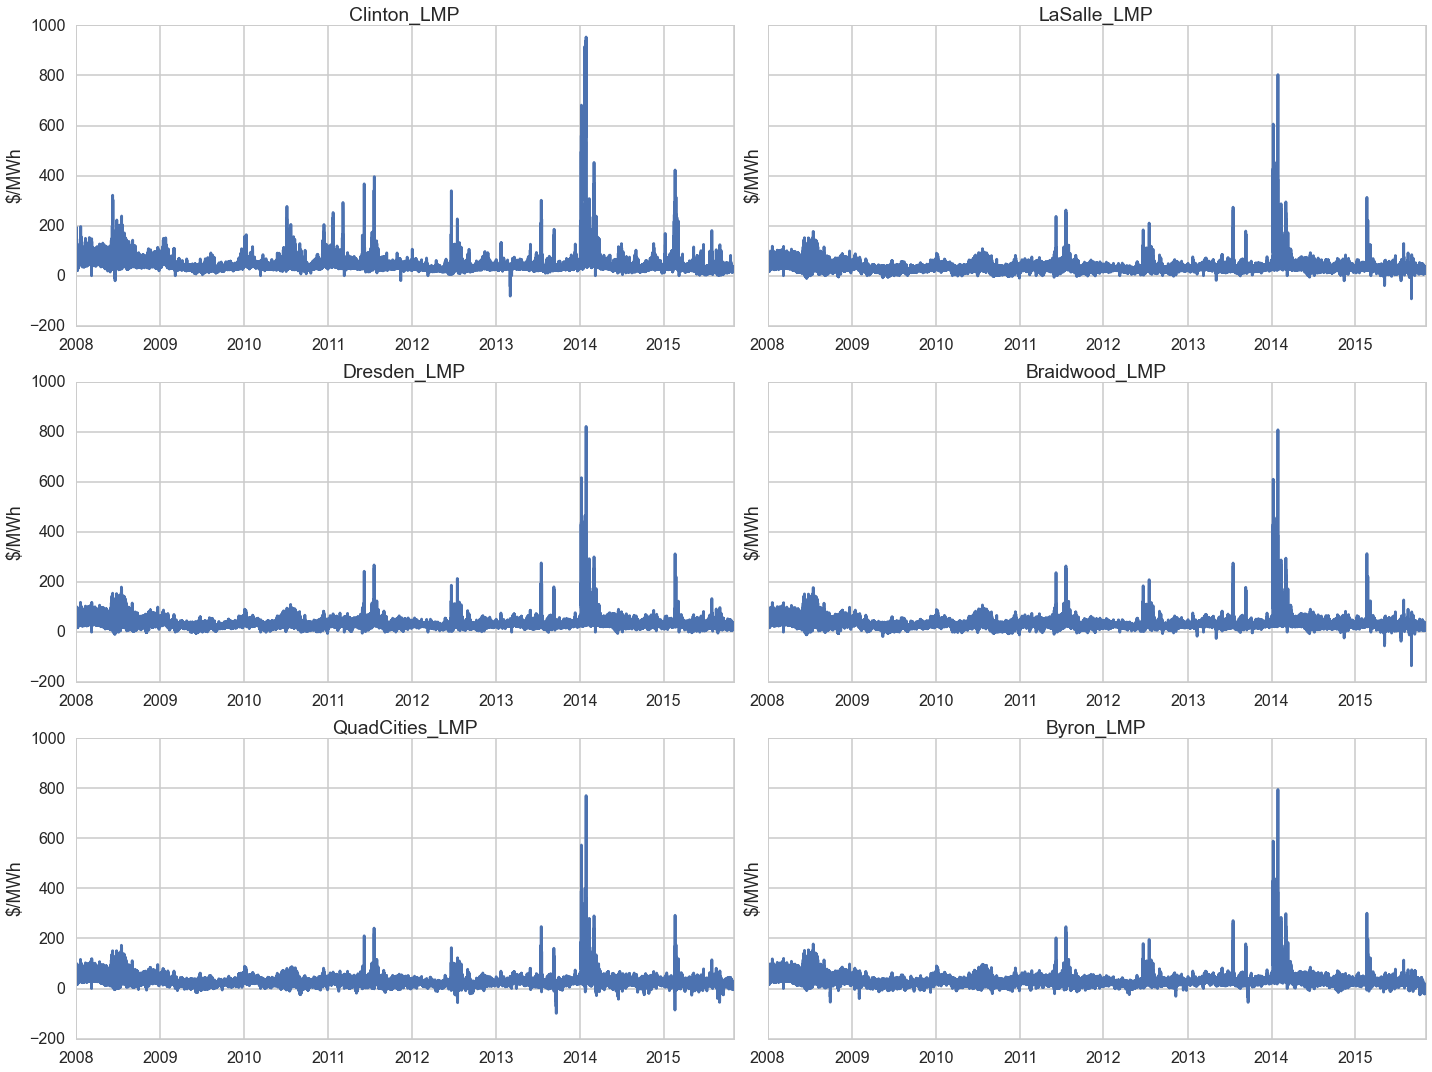

In [26]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15),tight_layout=True,sharey=True)
headers = list(lmpdf)
ax = axes.ravel()

for i in range(6):
    k = lmpdf.iloc[:,i]
    k.plot(ax=ax[i], title=headers[i])
    ax[i].set_ylabel("$/MWh")

###Histograms of each feature

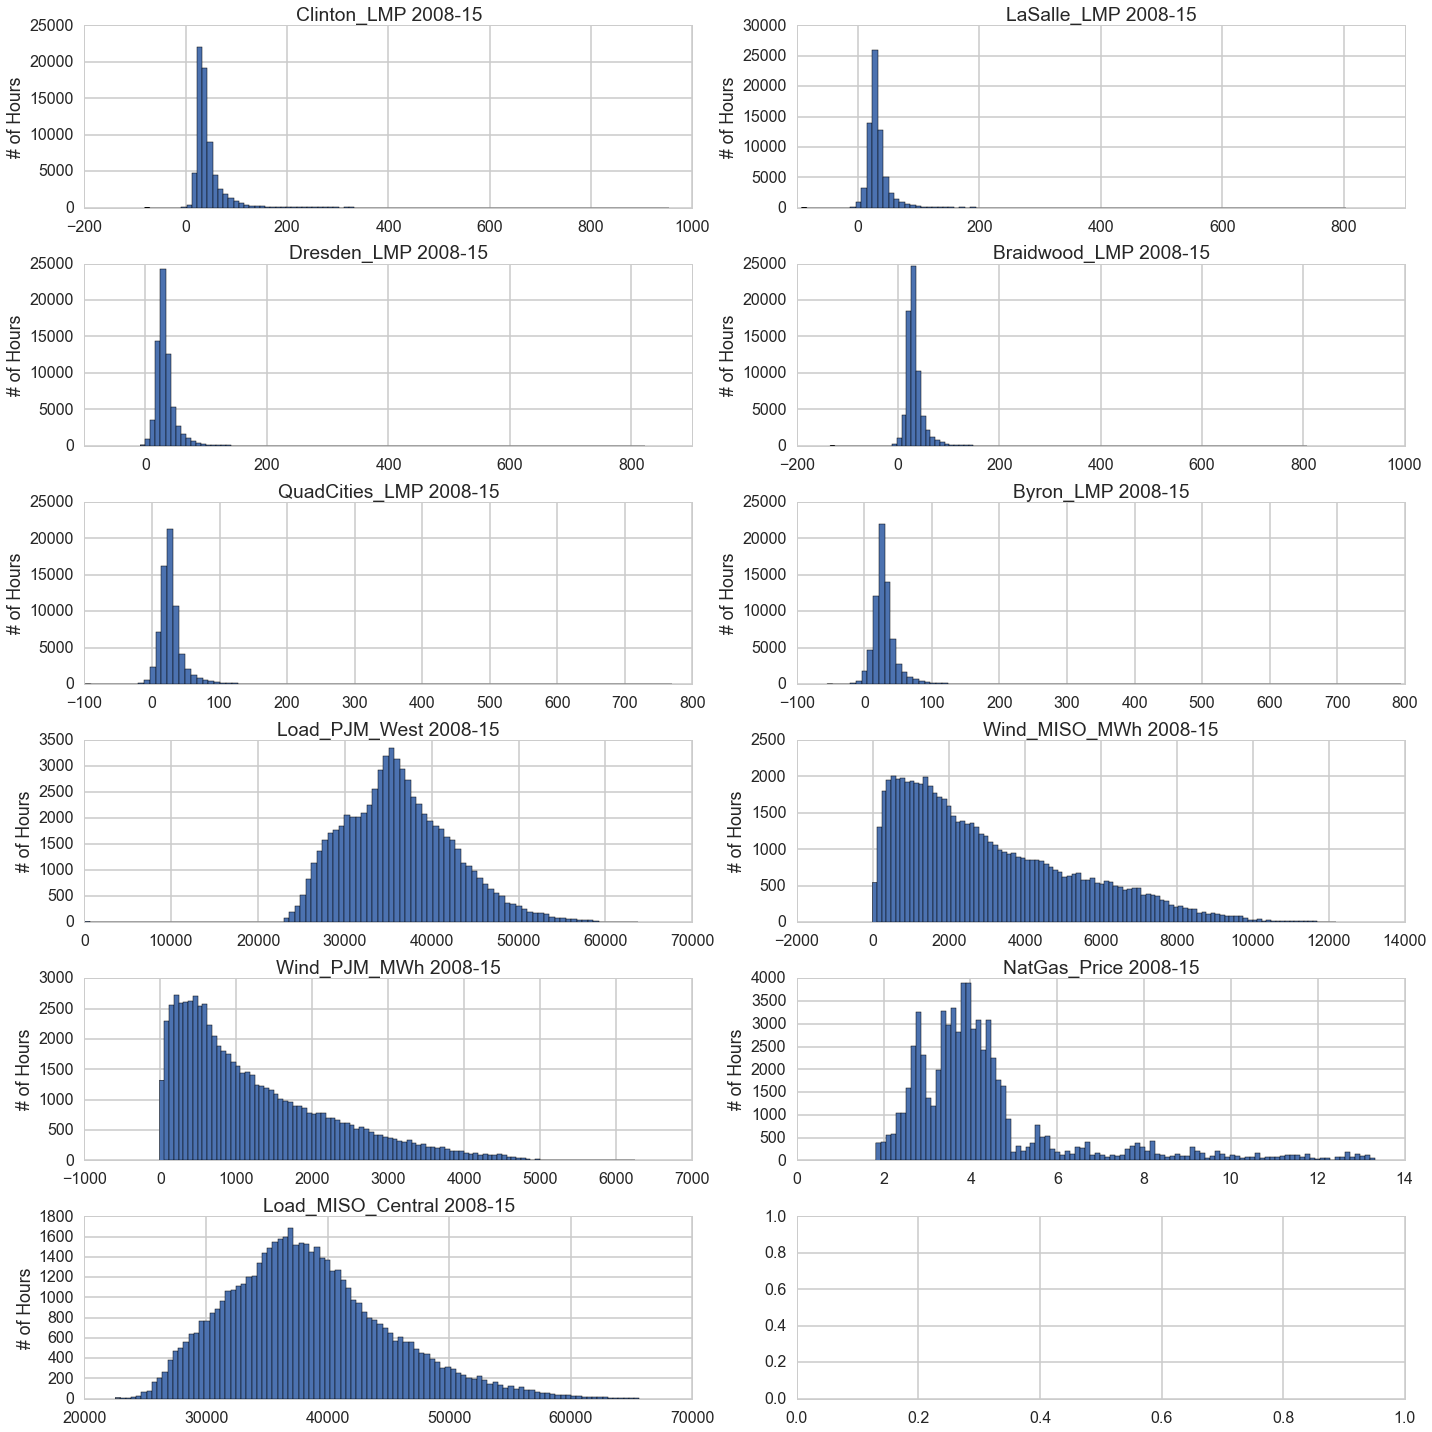

In [44]:
fig, axes = plt.subplots(nrows=6,ncols=2,figsize=(20,20),tight_layout=True)
headers = list(fulldf)
ax = axes.ravel()

for i in range(11):
    fulldf.iloc[:,i].hist(bins=100, ax=ax[i])
    ax[i].set_title(headers[i] + ' 2008-15')
    ax[i].set_ylabel("# of Hours")

Histograms of each of our data points shows that electricity prices and demand are (roughly) normally distributed, while wind and gas prices are closer to a poisson distribution.

###Scatter plots comparing features against electric price (Clinton)

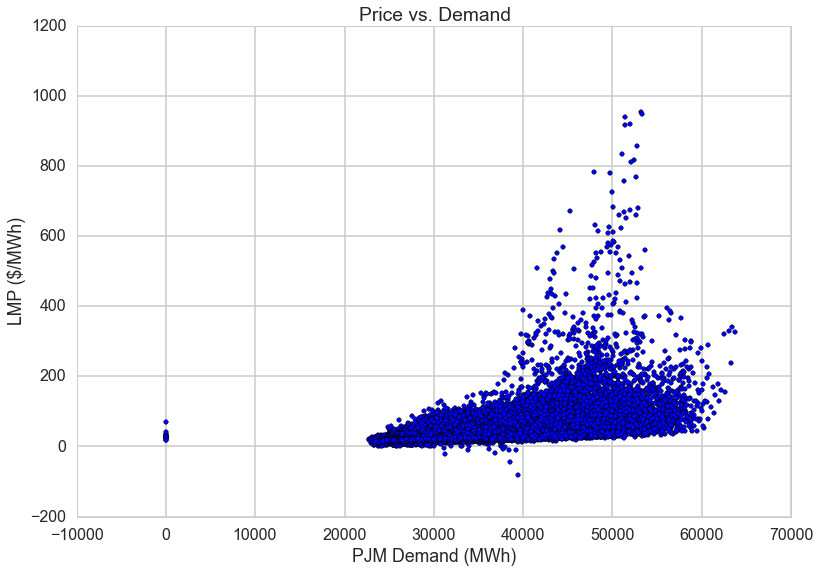

In [49]:
y = fulldf['Clinton_LMP']
x = fulldf['Load_PJM_West']
plt.scatter(x,y)
plt.xlabel('PJM Demand (MWh)')
plt.ylabel('LMP ($/MWh)')
plt.title('Price vs. Demand')

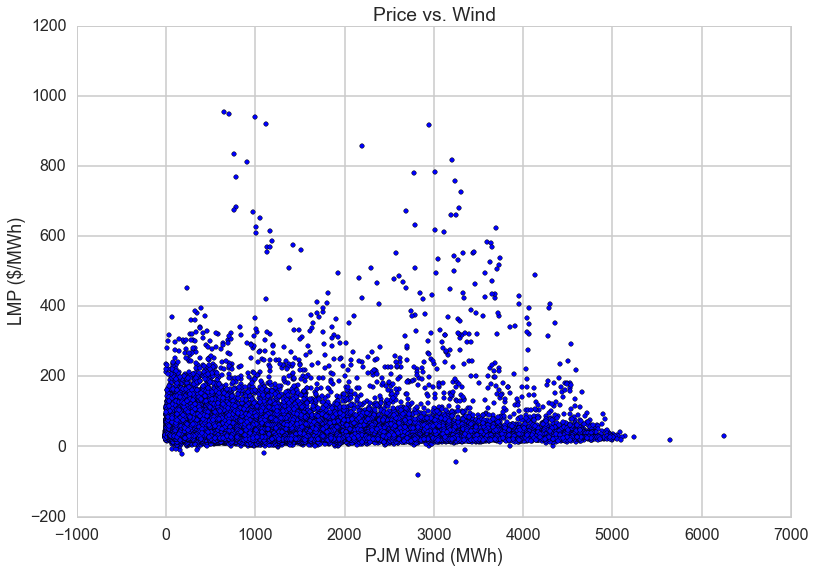

In [50]:
y = fulldf['Clinton_LMP']
x = fulldf['Wind_PJM_MWh']
plt.scatter(x,y)
plt.xlabel('PJM Wind (MWh)')
plt.ylabel('LMP ($/MWh)')
plt.title('Price vs. Wind')

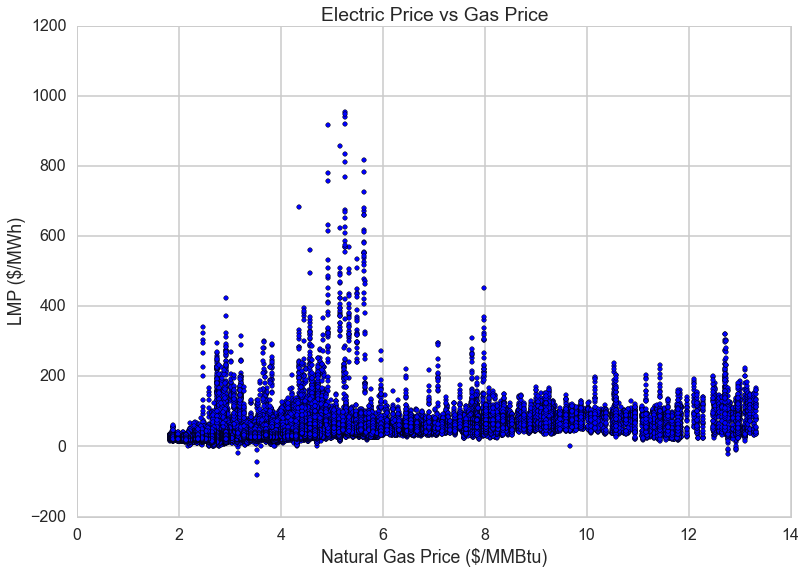

In [51]:
y = fulldf['Clinton_LMP']
x = fulldf['NatGas_Price']
plt.scatter(x,y)
plt.xlabel('Natural Gas Price ($/MMBtu)')
plt.ylabel('LMP ($/MWh)')
plt.title('Electric Price vs Gas Price')

##Final Analysis: Classification and Regression

###Multiple Linear Regression

In [56]:
import statsmodels.formula.api as smf

print "LMP_NODE    ", "   NG    ", "   PJM Load    ","   MISO Load    ","   PJM Wind    ","   MISO Wind   ", "   All minus MISO Load", "   All"
for lmp in list(fulldf)[0:6]:
    lm0 = smf.ols(formula = lmp + ' ~ NatGas_Price', data = fulldf).fit()
    lm1 = smf.ols(formula = lmp + ' ~ Load_PJM_West', data = fulldf).fit()
    lm2 = smf.ols(formula = lmp + ' ~ Load_MISO_Central', data = fulldf).fit()
    lm3 = smf.ols(formula = lmp + ' ~ Wind_PJM_MWh', data = fulldf).fit()
    lm4 = smf.ols(formula = lmp + ' ~ Wind_MISO_MWh', data = fulldf).fit()
    lm5 = smf.ols(formula = lmp + ' ~ NatGas_Price + Load_PJM_West + Wind_PJM_MWh + Wind_MISO_MWh', data = fulldf).fit()
    lm6 = smf.ols(formula = lmp + ' ~ NatGas_Price + Load_PJM_West + Wind_PJM_MWh + Wind_MISO_MWh + Load_MISO_Central', data = fulldf).fit()
    print lmp, ':   ', lm0.rsquared, lm1.rsquared, lm2.rsquared, lm3.rsquared, lm4.rsquared, lm5.rsquared, lm6.rsquared

LMP_NODE        NG        PJM Load        MISO Load        PJM Wind        MISO Wind       All minus MISO Load    All
Clinton_LMP :    0.155870426117 0.247574705583 0.179985571045 0.00759915146455 0.00674815154949 0.3650412534 0.281315289153
LaSalle_LMP :    0.136671738294 0.348381855218 0.295095451351 0.0200163738526 0.0130028462486 0.437645921674 0.356805631825
Dresden_LMP :    0.134290774542 0.346826117584 0.295985069593 0.0191234376246 0.0117192938701 0.434740920384 0.35713131386
Braidwood_LMP :    0.13739032207 0.348300427978 0.293317711292 0.0209962588914 0.0141746537575 0.437782975177 0.355544715941
QuadCities_LMP :    0.193208730516 0.307525146094 0.258956901098 0.0364742033846 0.0355512813481 0.445342074407 0.32887641194
Byron_LMP :    0.160775706423 0.330398286783 0.283677340925 0.0253652843335 0.0189055786615 0.439726728559 0.34911474435


Compare the second to last column against the last column - its strange that the adding the feature Load_MISO_Central (electricity demand in MISO) reduces the r^2. 

In [58]:
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Byron_LMP   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     5947.
Date:                Thu, 03 Dec 2015   Prob (F-statistic):               0.00
Time:                        21:27:04   Log-Likelihood:            -2.3179e+05
No. Observations:               55440   AIC:                         4.636e+05
Df Residuals:                   55434   BIC:                         4.637e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept           -49.4272      0.486   -101.662      0.000       -50.380   -48.474
NatGas_Price          4.7837      0.080     60.132      0.000         4.628     4.940
Load_PJM_West         0.0011   2.49e-05     44.549      0.000         0.001     0.001
Wind_PJM_MWh         -0.0008    7.7e-05    -10.031      0.000        -0.001    -0.001
Wind_MISO_MWh         0.0003   3.52e-05      9.927      0.000         0.000     0.000
Load_MISO_Central     0.0005   2.36e-05     21.344      0.000         0.000     0.001
==============================================================================
Omnibus:                   110286.240   Durbin-Watson:                   0.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        650603711.651
Skew:                          15.885   Prob(JB):                         0.00
Kurtosis:                     532.752   Cond. No.                     3.89e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###Ridge Regression

In [53]:
# Hourly
d = '2009-07-06 00:00:00'
lmp1df = fulldf.ix[d:]
lmp1df = lmp1df[['Clinton_LMP','NatGas_Price', 'Wind_MISO_MWh','Wind_PJM_MWh','Load_PJM_West','Load_MISO_Central']]
lmp1df.head(2)

,Clinton_LMP,NatGas_Price,Wind_MISO_MWh,Wind_PJM_MWh,Load_PJM_West,Load_MISO_Central
2009-07-06 00:00:00,22.08,3.24,313.94,92.4,28391.908,26274.67
2009-07-06 01:00:00,18.43,3.24,288.85,82.8,26837.006,25008.58


In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(lmp1df.drop('lmp_601', axis=1), lmp1df['lmp_601'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Try Ridge regression with daily data points

In [54]:
d = '2009-07-06 00:00:00'
dfulldf = fulldf.ix[d:]
dfulldf = dfulldf.groupby(pd.TimeGrouper('D')).transform(np.mean).resample('D') #, how='ohlc'
print "number of hourly data points: ", len(fulldf)
print "number of daily data points: ", len(dfulldf)

number of hourly data points:  68688
number of daily data points:  2310


In [ ]:
# Daily
d = '2009-07-06'
lmp1df = dfulldf.ix[d:]
lmp1df = lmp1df[['Clinton_LMP','NatGas_Price', 'Wind_MISO_MWh','Wind_PJM_MWh','Load_PJM_West','Load_MISO_Central']]
#lmp1df = lmp1df[['lmp_601','NG_HH', 'Wind_MISO','Wind_PJM','Load_PJM_West']]
lmp1df.head(2)

# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(lmp1df.drop('Clinton_LMP', axis=1), lmp1df['Clinton_LMP'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)

# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

###Random Forest

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn import grid_search
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy import stats

%%time
# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(lmp1df.drop('Clinton_LMP', axis=1), lmp1df['Clinton_LMP'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch
params = {
        'max_features': ['auto', 'sqrt', 'log2'],
        'n_estimators': [30,50,75,100],
        'max_depth': [None,1,2,3,5],
        'min_samples_split': [2,3,5]
}
clf = grid_search.GridSearchCV(RandomForestRegressor(n_jobs=3), params, cv=5, n_jobs=1)
fit = clf.fit(X_train, y_train)


# Best Estimator
rf = fit.best_estimator_


# Metrics
print 'Best Params: ', fit.best_params_
print 'Best Score: ', fit.best_score_
print
preds = rf.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Feature Importances
lcols = X_train.columns
pd.DataFrame(zip(lcols, rf.feature_importances_), columns=['Predictors', 'Feature Importances']).sort('Feature Importances', ascending=False)